In [ ]:
import os

#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import skimage.io as io

from glob import glob
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Input, Flatten, Dense

### Data Generator

A keras sequence that loads the data while the model is training.

In [ ]:
class DataSeq(tf.keras.utils.Sequence):

    def __init__(self, ids, labels, batch_size=8, image_size=224):
        self.ids = ids
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size

    def __load__(self, id_name):
        image_path = id_name
        image = io.imread(image_path) / 255.0

        return image

    def __getitem__(self, index):
        n = self.batch_size

        if (index + 1) * n > len(self.ids):
            n = len(self.ids) - index * self.batch_size

        files_batch = self.ids[index * n : (index + 1) * n]
        labels_batch = self.labels[index * n : (index + 1) * n]
        images = []

        for id in files_batch:
            image = self.__load__(id)
            images.append(image)

        images = np.array(images)

        return images, labels_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))

### VGG Model

Create a model using a VGG16. No data augmentation.

The neural network has 2 layers, a hidden layer with 4096 neurons and the output layer with 3 neurons since there are 3 classes.

No hyperparameter tuning has been done.

The weights were downloaded from: https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
def build_transfer_vgg(input_shape):
    input_layer = Input(shape=input_shape)

    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=input_layer)
    vgg.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)
    model = Dense(4096, activation='relu')(model)
    model = Dense(3, activation='softmax')(model)

    model = Model(input_layer, model, name="Transfer_VGG16")
    return model

Dataset: https://drive.google.com/drive/folders/1yWT1aaQLiZAkAomtAdFlqlVWnRkhNrCu

The images are located in three separate folders: 1, 2 and 3. This indicates the image's class.

The labels were encoded using one-hot.

In [ ]:
def load_ids(path):
    ids = []
    labels = []

    for root, dirs, files in os.walk(path):
        for i in range(len(files)):
            ids.append(os.path.join(root, files[i]))
            labels.append(int(root[-1]))

    ids = np.array(ids)
    labels = np.array(labels) - 1
    labels_onehot = tf.one_hot(labels, 3, on_value=1.0, off_value=0.0).numpy()

    return ids, labels_onehot

In [ ]:
path = "./Train_non_experts_simple/"
ids, labels = load_ids(path)
print(ids.shape, labels.shape)
X_train, X_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, random_state=42)

(75243,) (75243, 3)


In [ ]:
batch_size = 8
epochs = 5

train_seq = DataSeq(X_train, y_train)
valid_seq = DataSeq(X_valid, y_valid)

train_steps = len(X_train) // batch_size
valid_steps = len(X_valid) // batch_size

model = build_transfer_vgg((224, 224, 3))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "Transfer_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)    

In [ ]:
history = model.fit(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
   validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
7524/7524 [==============================] - 399s 53ms/step - loss: 0.4826 - accuracy: 0.8234 - val_loss: 0.3896 - val_accuracy: 0.8444
Epoch 2/5
7524/7524 [==============================] - 401s 53ms/step - loss: 0.3564 - accuracy: 0.8560 - val_loss: 0.3787 - val_accuracy: 0.8454
Epoch 3/5
7524/7524 [==============================] - 400s 53ms/step - loss: 0.3265 - accuracy: 0.8691 - val_loss: 0.4098 - val_accuracy: 0.8390
Epoch 4/5
7524/7524 [==============================] - 402s 53ms/step - loss: 0.3024 - accuracy: 0.8782 - val_loss: 0.3829 - val_accuracy: 0.8516
Epoch 5/5
7524/7524 [==============================] - 406s 54ms/step - loss: 0.2859 - accuracy: 0.8861 - val_loss: 0.4291 - val_accuracy: 0.8363


546/546 [==============================] - 17s 32ms/step


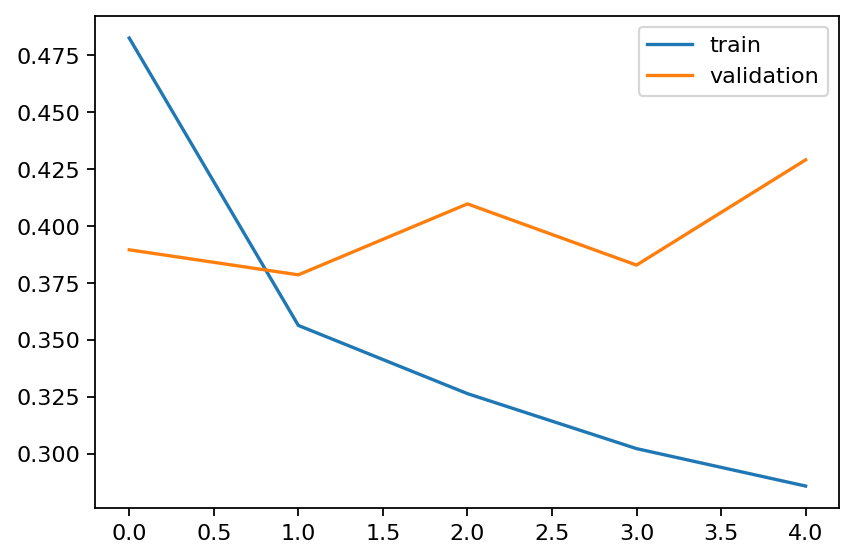

In [ ]:
test_path = "./Test/"
test_ids, test_labels = load_ids(test_path)
test_seq = DataSeq(test_ids, test_labels)

y_pred = model.predict(test_seq)

# TODO: This creates some predictions (near a 100) with no classfication and needs to be re tested.
y_pred = (y_pred > 0.5).astype(int)


plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

#### This needs to be redone, but the results should be nearly the same.

In [ ]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      2692
           1       0.61      0.86      0.72      1196
           2       0.94      0.59      0.72       476

   micro avg       0.79      0.78      0.78      4364
   macro avg       0.82      0.74      0.76      4364
weighted avg       0.83      0.78      0.79      4364
 samples avg       0.78      0.78      0.78      4364



/home/mlbros/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### VGG16 with data augmentation

Same VGG16 model as before, but with a RandomFlip and RandomRotation layer.

In [ ]:
 def build_transfer_vgg_aug(input_shape):
    input_layer = Input(shape=input_shape)

    data_augmentation = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ])

    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=data_augmentation.output)
    vgg.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)
    model = Dense(4096, activation='relu')(model)
    model = Dense(3, activation='softmax')(model)

    model = Model(input_layer, model, name="Transfer_VGG16")
    return model

In [ ]:
model_aug = build_transfer_vgg_aug((224, 224, 3))
model_aug.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_aug.summary()

Model: "Transfer_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                    

In [ ]:
history_aug = model_aug.fit(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
   validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
7524/7524 [==============================] - 422s 56ms/step - loss: 0.4827 - accuracy: 0.8153 - val_loss: 0.4457 - val_accuracy: 0.8155
Epoch 2/5
7524/7524 [==============================] - 418s 56ms/step - loss: 0.3887 - accuracy: 0.8417 - val_loss: 0.3943 - val_accuracy: 0.8421
Epoch 3/5
7524/7524 [==============================] - 417s 55ms/step - loss: 0.3755 - accuracy: 0.8494 - val_loss: 0.4003 - val_accuracy: 0.8371
Epoch 4/5
7524/7524 [==============================] - 418s 56ms/step - loss: 0.3669 - accuracy: 0.8521 - val_loss: 0.3945 - val_accuracy: 0.8428
Epoch 5/5
7524/7524 [==============================] - 420s 56ms/step - loss: 0.3599 - accuracy: 0.8558 - val_loss: 0.3553 - val_accuracy: 0.8598


546/546 [==============================] - 17s 32ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2692
           1       0.73      0.78      0.75      1196
           2       0.86      0.67      0.76       476

    accuracy                           0.83      4364
   macro avg       0.82      0.78      0.80      4364
weighted avg       0.84      0.83      0.83      4364



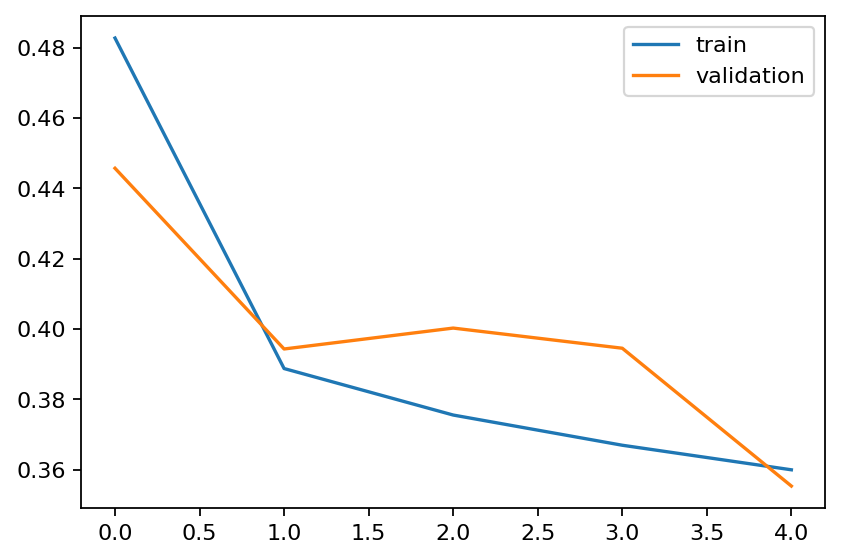

In [ ]:
y_pred_aug = model_aug.predict(test_seq)
y_pred_aug = np.argmax(y_pred_aug,axis=1)
print(classification_report(np.argmax(test_labels, axis=1), y_pred_aug))

plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history_aug.history["loss"], label="train")
plt.plot(history_aug.history["val_loss"], label="validation")
plt.legend()
plt.show()

### Testing the pickle file

In [ ]:
pkl_path = "./train_crowdsourced_labels.pkl"
df = pd.read_pickle(pkl_path)
df

,annotations,label,patch
0,"[[13, 1], [23, 1], [17, 2], [7, 1], [5, 1], [1...",1.0,TCGA-A1-A0SK-DX1_xmin47201_ymin23382_A0SK_A1_x...
1,"[[13, 1], [23, 1], [17, 2], [7, 1], [5, 1], [1...",1.0,TCGA-A1-A0SK-DX1_xmin47201_ymin23382_A0SK_A1_x...
2,"[[13, 1], [23, 1], [17, 2], [7, 1], [5, 1], [1...",1.0,TCGA-A1-A0SK-DX1_xmin47201_ymin23382_A0SK_A1_x...
3,"[[13, 1], [23, 1], [17, 2], [7, 1], [5, 1], [1...",1.0,TCGA-A1-A0SK-DX1_xmin47201_ymin23382_A0SK_A1_x...
4,"[[13, 1], [23, 1], [17, 1], [7, 1], [5, 1], [1...",1.0,TCGA-A1-A0SK-DX1_xmin47201_ymin23382_A0SK_A1_x...
...,...,...,...
75238,"[[5, 3]]",3.0,TCGA-S3-AA10-DX1_xmin43039_ymin23986_AA10_S3_x...
75239,"[[5, 3]]",3.0,TCGA-S3-AA10-DX1_xmin43039_ymin23986_AA10_S3_x...
75240,"[[5, 3]]",3.0,TCGA-S3-AA10-DX1_xmin43039_ymin23986_AA10_S3_x...
75241,"[[5, 3]]",3.0,TCGA-S3-AA10-DX1_xmin43039_ymin23986_AA10_S3_x...


In [ ]:
print(df["annotations"][0])
print(df["patch"][0])
print(df["label"][0])

[[13  1]
 [23  1]
 [17  2]
 [ 7  1]
 [ 5  1]
 [11  1]
 [12  1]
 [21  1]
 [19  1]
 [ 8  1]
 [10  1]
 [22  1]
 [14  1]
 [24  1]
 [20  1]
 [ 9  1]
 [15  1]]
TCGA-A1-A0SK-DX1_xmin47201_ymin23382_A0SK_A1_x_ini_0_y_ini_0.png
1.0
